In [2]:
import json
import numpy as np
import requests

import zlib
from io import BytesIO
from urllib import request as urlrequest

from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt

%matplotlib inline

classes = ['d10','d12','d20','d4','d6','d8','dicesback']


def uncompress_nparr(bytestring):
    """
    code from https://gist.github.com/andres-fr/f9c0d5993d7e7b36e838744291c26dde
    """
    return np.load(BytesIO(zlib.decompress(bytestring)), allow_pickle=True)


def download_image(url):
    
    with urlrequest.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img.resize((64,64), Image.NEAREST)

lst = [
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230109_011654__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230109_013921__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230109_014133__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230110_205235__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230110_205256__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230110_205346__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230110_205406__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230110_205427__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011213__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011222__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011232__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011243__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011252__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011303__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011323__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011335__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011343__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230111_011354__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/IMG_20230112_193332__01.jpg"
]

lst_d10 = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d10/IMG_20230110_205427__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d10/IMG_20230112_192635__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d10/IMG_20230112_192652__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d10/IMG_20230112_192848__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d10/IMG_20230112_192853__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d10/IMG_20230112_193157__01.jpg"
]

lst_d12 = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_192520__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_192534__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_192546__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_192834__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_192841__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_193148__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_193213__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_193259__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_193327__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d12/IMG_20230112_193332__01.jpg"
]

lst_d20 = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230110_205406__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_192626__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_192722__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_192933__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_192939__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_192939__02.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_193253__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d20/IMG_20230112_193309__01.jpg"
]

lst_d4 = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230110_205235__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230110_205256__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_192658__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_192703__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_192758__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_192807__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_192900__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_192912__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_193052__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_193106__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_193125__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d4/IMG_20230112_193131__01.jpg",
]

lst_d6 = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d6/IMG_20230112_192616__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d6/IMG_20230112_192709__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d6/IMG_20230112_192816__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d6/IMG_20230112_193207__01.jpg",
]

lst_d8 = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230109_011654__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230109_013921__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230110_205346__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_192641__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_192646__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_192715__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_192920__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_192927__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_193034__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_193041__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_193224__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/d8/IMG_20230112_193231__01.jpg",
]

lst_back = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-IMG_20230110_205256__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d20_color001.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d20_color223.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d20_color338.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d20_color501.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d20_color604.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d20_off-angle_0231.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d8_color095.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d8_color263.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d8_color351.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d8_wood611.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/back/back-d8_wood888.jpg"
]

lst_few = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/few-dices/IMG_20230109_014133__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/few-dices/IMG_20230116_002416__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/few-dices/IMG_20230116_002559__01.jpg"
]

lst_new = [
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230112_193327__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_165805__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_165836__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_170052__01.jpg",
	"https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_170104__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_170113__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_170132__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_170141__01.jpg",
    "https://storage.yandexcloud.net/ybs-123123/dices-480x480/new/IMG_20230121_170152__01.jpg"
]
with open("test-urls.txt", "rt") as f_in:
    urls=f_in.read()

lst_urls = urls.replace("\n", "").replace('"', '').split(",")

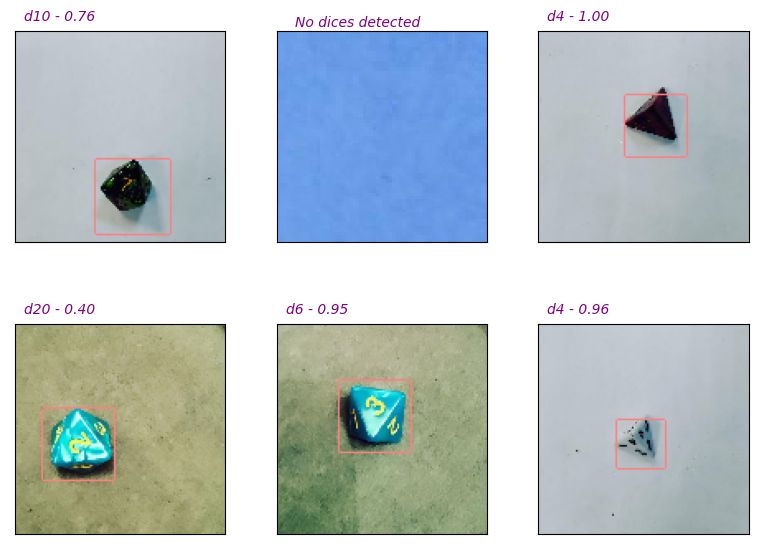

In [52]:
# url = "http://localhost:9696/predict" # uncomment for testing local Flask app
url = "http://localhost:8080/predict" # for testing Kubernetes deployment

N = 6 # number of samples to predict and plot - better to be even

idx = np.random.choice(lst_urls, size=N, replace=False)
random_samples = idx

fig, axes = plt.subplots(2, N//2, figsize=(8, 6))
axes = axes.flatten()


for i, test_url in enumerate(random_samples):
    test = {'url': test_url}

    response = requests.post(url, json=test)
    
    try:
        np_arr = uncompress_nparr(response.content)
        class_labels, result = np_arr[0], np_arr[1]
        
        titles=str()
        for label in class_labels:
            class_prob = sorted(dict(zip(classes, label)).items(), reverse=True, key=lambda x: x[1])[0]
            titles +=f"{class_prob[0]} - {class_prob[1]:.2f}\n"

        if isinstance(result, np.ndarray):
            axes[i].imshow(((result + 1.)*127.5).astype('int'))
            axes[i].text(5,3, titles, color='purple', fontstyle='italic')
            
    except:
        sample_img_original = download_image(test_url)
        axes[i].imshow(np.array(sample_img_original))
        axes[i].text(5, -2, "No dices detected", color='purple', fontstyle='italic')

plt.tight_layout()

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()